5장의 RNN은 과거의 정보를 기억할 수 있었지만 성능이 좋지 못하다.   
주된 원인은 시계열 데이터에서 시간적으로 멀리 떨어진 장기 의존 관계를 잘 학습할 수 없다는 것.  통칭 `Long Term Dependency Problem`! 

이번 장에서는 `LSTM`이나 `GRU`와 같은 게이트가 추가된 RNN을 알아보자.

# RNN의 문제점

RNN은 시계열 데이터의 장기 의존 관계를 학습하지 못한다.    
그 원인은 BPTT<sup>Backpropagation Through Time</sup>에서 기울기 소실 `Vanishing Gradients` 혹은 기울기 폭발 `Exploding Gradients` 이 일어나기 때문!

wowwow

## 기울기 소실 또는 기울기 폭발

<img src = "../imgs/fig 6-3.png" width = "500" align = "center">

5장에서 다뤘던 RNNLM이 `?`를 `Tom`으로 올바르게 예측하기 위해서는 현재 맥락에서 
1. Tom이 방에서 TV를 보고 있음
2. 그 방에 Mary가 들어옴 

의 정보들을 기억해야 한다.

BUT 현재 RNN계층에서는 기울기 소실 혹은 기울기 폭발이 일어나서 최종 목적지 Tom까지 가중치 매개변수가 도달하지 않게 된다.   
**학습이 안 되는 것!**

## 기울기 소실과 기울기 폭발의 원인

<img src = "../imgs/fig 6-5.png" width = "700" align = "center">


- T 번째 정답 레이블은 Tom
- 기울기는 차례로 `tanh`, `+`, `MatMul`(행렬 곱) 연산을 통과한다


    1. `+`의 역전파는 상류에서 전해지는 기울기를 하류로 그대로 흘려보낸다

    2. `tanh`는 역전파 시에 $1-y^2$로 흘러간다 이때 값은 1 이하이고 x가 0으로부터 멀어질 수록 작아진다
    
        - 이는 즉, 역전파 시에 `tanh`를 만날때마다 기울기가 매우 작아진다는 것!
        - `tanh`를 T번 통과하면 기울기도 T번 반복해서 작아짐!
        ==> **ReLU 함수를 이용해서 개선!**

    3. 역전파 시에 기울기는 MatMul을 만날 때마다 어떻게 변할까?

### 기울기 실험 1

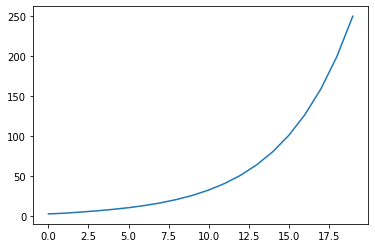

In [22]:
import numpy as np
import matplotlib.pyplot as plt

N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터 차원 수 
T = 20 # 시계열 데이터의 길이 

dh = np.ones((N,H))
np.random.seed(3) # 재현할 수 있도록 난수 고정
Wh = np.random.randn(H,H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T) # 역전파의 노드 수 만큼 dh를 갱신
    norm = np.sqrt(np.sum(dh**2)) / N # dh의 크기 : L2 norm 사용
    norm_list.append(norm) # 각 단계에서 dh의 크기를 norm_list에 추가
    
plt.plot(norm_list)
plt.show()

기울기가 시간에 비례해 지수적으로 증가함! 이것이 바로 `Exploding Gradients`

기울기 폭발이 일어나면 Overflow를 일으켜 결국 NaN같은 값을 발생시킨다. 신경망 학습이 제대로 수행 안 됨.

### 기울기 실험 2

```python
# Wh = np.random.randn(H,H) # 변경 전
Wh = np.random.randn(H,H) * 0.5 # 변경 후
```

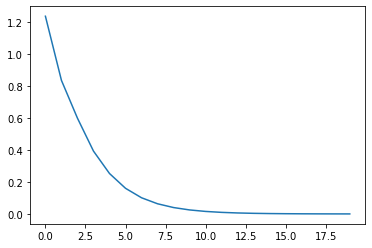

In [24]:
import numpy as np
import matplotlib.pyplot as plt

N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터 차원 수 
T = 20 # 시계열 데이터의 길이 

dh = np.ones((N,H))
np.random.seed(3) # 재현할 수 있도록 난수 고정
#Wh = np.random.randn(H,H) # 변경 전
Wh = np.random.randn(H,H) * 0.5 # 변경 후

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T) # 역전파의 노드 수 만큼 dh를 갱신
    norm = np.sqrt(np.sum(dh**2)) / N # dh의 크기 : L2 norm 사용
    norm_list.append(norm) # 각 단계에서 dh의 크기를 norm_list에 추가
    
plt.plot(norm_list)
plt.show()

반대로 기울기가 지수적으로 감소함! 이것이 `Vanishinng Gradients`

기울기 소실이 일어나면 기울기가 매우 빠르게 작아져 가중치 매개변수가 더 이상 갱신되지 않아 학습 효과가 발생하지 않음.

### 기울기 소실 혹은 기울기 폭발 원인

이러한 지수적인 변화가 일어나는 이뉴는 행렬 Wh를 T번 반복해서 곱했기 때문

Wh가 스칼라라면? 
   -  1보다 크면 지수적으로 증가하고, 1보다 작으면 지수적으로 감소

Wh가 스칼라가 아니라 행렬이라면?
   - 행렬의 특잇값이 척도가 된다. 
   - 행렬의 특잇값이란, 간단히 말해 데이터가 얼마나 퍼져있는 지를 나타냄.
   - 특잇값의 최댓값이 1보다 크면 지수적으로 증가하고 1보다 작으면 지수적으로 감소할 가능성이 높음..! (안 그럴 수도)

## 기울기 폭발 대책

기울기 폭발의 대책으로 전통적인 기법. 기울기 클리핑 `Gradients clipping`.

$$ {if}\ \lVert \hat{g}\rVert \ge threshold : $$

$$\hat{g} = \frac{threshold}{\lVert \hat{g}\rVert}\hat{g}$$

- $\hat{g}$ ; 기울기 통칭
- $\lVert \hat{g}\rVert$ : L2 norm 

**기울기의 l2 norm이 threshold를 초과하면 두 번째 줄의 수식처럼 기울기를 수정한다. 기울기 깎음.**

In [36]:
import numpy as np

dW1 = np.random.rand(3,3) * 10
dW2 = np.random.rand(3,3) * 10
grads = [dW1, dW2]
max_norm = 5.0 #threshold

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
        
    rate = max_norm / (total_norm + 1e-6)
    if total_norm >= max_norm :
        for grad in grads:
            grad *= rate
            
display("clipping 전", grads)
clip_grads(grads,max_norm)
print()
display("clipping 후", grads)

'clipping 전'

[array([[3.40688484, 0.64673198, 8.64119669],
        [2.90872446, 7.41082406, 1.58033655],
        [6.94963435, 8.41419619, 7.27152079]]),
 array([[3.59107525, 7.26689751, 1.39467124],
        [3.13819115, 4.19582757, 8.77212039],
        [1.53740209, 8.8012479 , 7.98964319]])]

'clipping 후'

[array([[0.67320956, 0.12779597, 1.70752359],
        [0.57477174, 1.46439866, 0.31227873],
        [1.37326634, 1.66266768, 1.43687196]]),
 array([[0.70960608, 1.43595839, 0.27559077],
        [0.62011497, 0.82910675, 1.73339446],
        [0.30379477, 1.73915013, 1.57877487]])]

# 기울기 소실과 LSTM

기울기 소실 문제를 해결하기 위해서는 RNN 계층을 갈아엎어야함! 

==> **게이트가 추가된 RNN**. 대표적인 신경망에는 LSTM과 GRU가 있다.

이번 장에서는 LSTM에 집중하고 도식은 간소화하여 설명함

## LSTM의 인터페이스

<img src = "../imgs/fig 6-11.png" width = "600" align = "center">

- LSTM 계층의 인터페이스에는 **c**라는 경로가 있다
    - **이 c은 memory cell 혹은 cell 이라고 하며, LSTM 전용의 기억 매커니즘이다.**
    - 기억 셀은 LSTM 계층 내에서만 작동. LSTM 계층 내에서만 완결되고, 다른 계층으로는 출력하지 않음.
    
    
- LSTM의 은닉 상태 h는 RNN 계층과 마찬가지로 가른 계층으로 출력됨.